<a href="https://colab.research.google.com/github/ZyadMohamed1/MRI-cycleGAN/blob/main/MriTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unrar x -Y "/content/drive/MyDrive/MRI+T1_T2+Dataset.RAR"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/MRI+T1_T2+Dataset.RAR

Creating    Tr1                                                       OK
Extracting  Tr1/.DS_Store                                                  0%  OK 
Creating    Tr1/TrainT1                                               OK
Extracting  Tr1/TrainT1/Image #10.png                                      1%  OK 
Extracting  Tr1/TrainT1/Image #11.png                                      2%  OK 
Extracting  Tr1/TrainT1/Image #12.png                                      3%  OK 
Extracting  Tr1/TrainT1/Image #13.png                                      4%  OK 
Extracting  Tr1/TrainT1/Image #14.png                                      5%  OK 
Extracting  Tr1/TrainT1/Image #15.png                                      6%  OK 
Extracting  Tr1/TrainT1/Image #16.png                                      

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras_preprocessing.image
import os

In [3]:
#Data Preparation Stage
from keras_preprocessing.image.utils import img_to_array
def prepare_image(path):

  imageList = []

  for imageName in os.listdir(path):
    #image Resizing and convert it to numpy array
    imagePixels = keras_preprocessing.image.load_img(path + imageName, target_size=(256,256))
    imagePixels = img_to_array(imagePixels)
    imageList.append(imagePixels)
  
  return imageList


#convert images from List to Array
Tr1 = np.asarray(prepare_image('/content/Tr1/TrainT1/'))
Tr2 = np.asarray(prepare_image('/content/Tr2/TrainT2/'))

print(Tr1.shape , Tr2.shape)

#Convert images from RGB = 3 to GreyScale = 1
Tr1 = tf.image.rgb_to_grayscale(Tr1)
Tr2 = tf.image.rgb_to_grayscale(Tr2)

print(Tr1.shape , Tr2.shape)

#Take a sample from the data
Tr1_slice = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(Tr1))
Tr2_slice = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(Tr2))

print(Tr1_slice, Tr2_slice)


(43, 256, 256, 3) (46, 256, 256, 3)
(43, 256, 256, 1) (46, 256, 256, 1)
<TensorSliceDataset element_spec=TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None)> <TensorSliceDataset element_spec=TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None)>


In [4]:
#Data Processing Stage
AUTOTUNE = tf.data.AUTOTUNE

BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256


def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 1])

  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # resizing to 286 x 286 x 1
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 1
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

def preprocess_image_train(image):
  image = random_jitter(image)
  image = normalize(image)
  return image




In [5]:

Tr1_slice = Tr1_slice.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)
Tr2_slice = Tr2_slice .map(preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle( BUFFER_SIZE).batch(BATCH_SIZE)


In [6]:
Tr1_sample = next(iter(Tr1_slice))
Tr2_sample = next(iter(Tr2_slice))

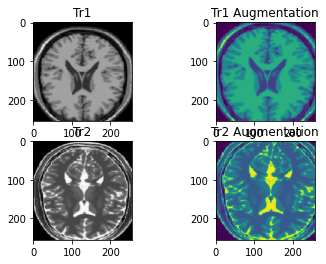

In [7]:
plt.subplot(221)
plt.title('Tr1')
plt.imshow(Tr1_sample[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

plt.subplot(222)
plt.title('Tr1 Augmentation')
plt.imshow(preprocess_image_train(Tr1_sample[0]).numpy()[:, :, 0] * 0.5 + 0.5)

plt.subplot(223)
plt.title('Tr2')
plt.imshow(Tr2_sample[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

plt.subplot(224)
plt.title('Tr2 Augmentation')
plt.imshow(preprocess_image_train(Tr2_sample[0]).numpy()[:, :, 0] * 0.5 + 0.5)

In [8]:
!pip install -q git+https://github.com/tensorflow/examples.git


    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [9]:
#Model Building
#Using A U-Net Based Discriminator for Generative Adversarial Networks
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset
#Downsampling
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(InstanceNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result
#upSampling
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [10]:
def unet_generator():
   
    down_stack = [
      downsample(64, 4, apply_norm=False), 
      downsample(128, 4), 
      downsample(256, 4),  
      downsample(512, 4),  
      downsample(512, 4), 
      downsample(512, 4),  
      downsample(512, 4),  
      downsample(512, 4),  
    ]
    #create a stack of downsample models
    up_stack = [
      upsample(512, 4, apply_dropout=True),  
      upsample(512, 4, apply_dropout=True),  
      upsample(512, 4, apply_dropout=True),  
      upsample(512, 4),  
      upsample(256, 4),  
      upsample(128, 4),  
      upsample(64, 4),  
               ] #create a stack of upsample models
        
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') 
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

generator_g = unet_generator() 
generator_f = unet_generator()

In [12]:
#Discriminator
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[None, None, 1], name='input_image')
    x = inp
    down1 = downsample(64, 4,  False)(x)  
    down2 = downsample(128, 4)(down1)     
    down3 = downsample(256, 4)(down2)    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
  
    return tf.keras.Model(inputs=inp, outputs=last) 

discriminator_x = discriminator()
discriminator_y = discriminator()

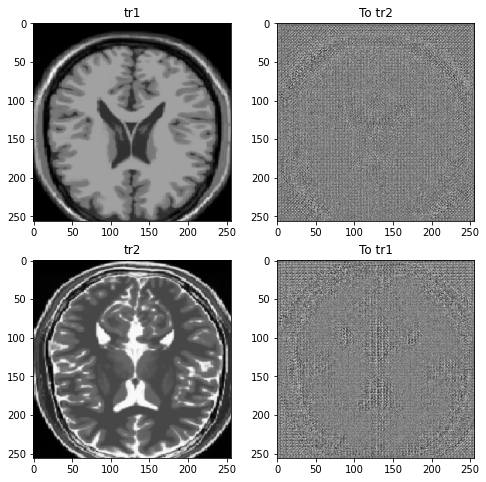

In [14]:
to_tr2 = generator_g(Tr1_sample)
to_tr1 = generator_f(Tr2_sample)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [Tr1_sample, to_tr2, Tr2_sample, to_tr1]
title = ['tr1', 'To tr2', 'tr2', 'To tr1']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    else:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 * contrast + 0.5, cmap='gray')
plt.show()

In [15]:
LAMBDA = 10
# Using Binarycross entropy with logits true
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# calculating discriminator loss by summing the real and generated
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real) 
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss 
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image)) 
    return LAMBDA * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

# Optimizer with learning rate 0.0001 for generator and discriminator
generator_g_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)

In [17]:
EPOCHS = 10 
checkpoint_path = './checkpoints'  
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=EPOCHS)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [18]:
def generate_images(model, test_input, expected_output):
    prediction = model(test_input)
    plt.figure(figsize=(10, 10))
    display_list = [test_input[0], prediction[0], expected_output[0]]
    title = ['Input Image', 'Predicted Image', 'Expected Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

In [19]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        fake_y = generator_g(real_x, training=True) 
        cycled_x = generator_f(fake_y, training=True) 
        
        fake_x =  generator_f(real_y, training=True) 
        cycled_y = generator_g(fake_x, training=True) 
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True) 
        same_y = generator_g(real_y, training=True) 
        
        disc_real_x =  discriminator_x(real_x, training=True) 
        disc_real_y = discriminator_y(real_y, training=True) 
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y) # calculate the generator_loss for disc_fake_
        gen_f_loss = generator_loss(disc_fake_x) # calculate the generator_loss for disc_fake_X 
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
 #calculate the total cycle loss
        
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x) # calculate the discriminator_loss for disc_fake_x wrt disc_real_x
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y) # calculate the discriminator_loss foor disc_fake_y wrt disc_real_y
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables) 
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables) 
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

    
    # Apply the gradients to the optimizer
    
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables)) 

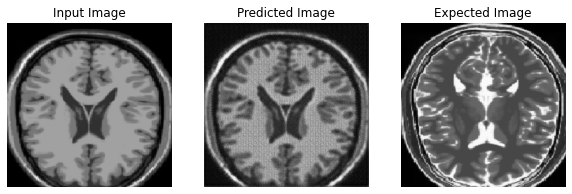

Saving checkpoint for epoch 0 at ./checkpoints/ckpt-1


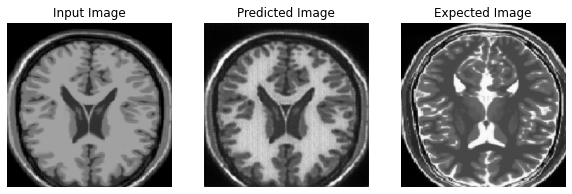

Saving checkpoint for epoch 1 at ./checkpoints/ckpt-2


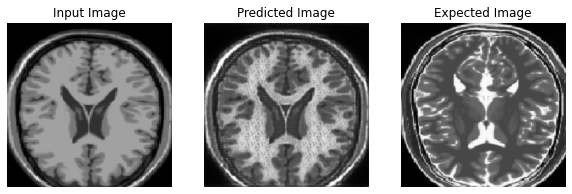

Saving checkpoint for epoch 2 at ./checkpoints/ckpt-3


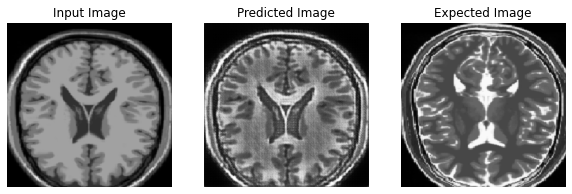

Saving checkpoint for epoch 3 at ./checkpoints/ckpt-4


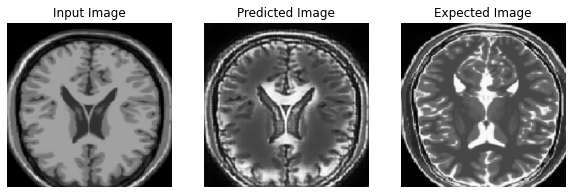

Saving checkpoint for epoch 4 at ./checkpoints/ckpt-5


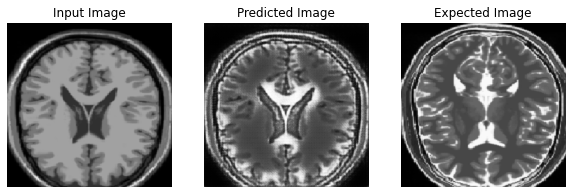

Saving checkpoint for epoch 5 at ./checkpoints/ckpt-6


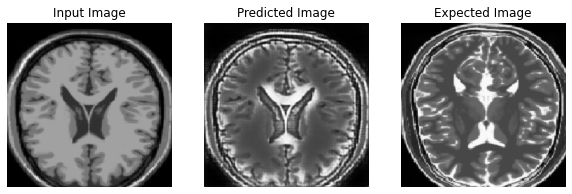

Saving checkpoint for epoch 6 at ./checkpoints/ckpt-7


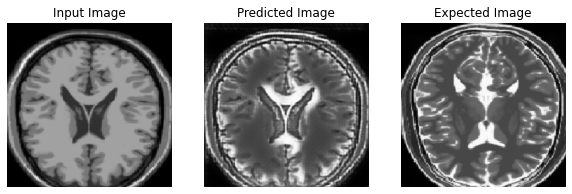

Saving checkpoint for epoch 7 at ./checkpoints/ckpt-8


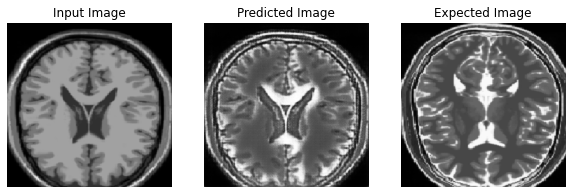

Saving checkpoint for epoch 8 at ./checkpoints/ckpt-9


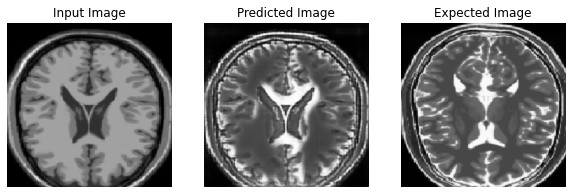

Saving checkpoint for epoch 9 at ./checkpoints/ckpt-10


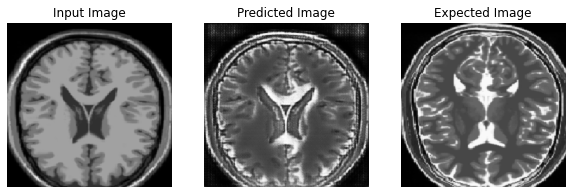

Saving checkpoint for epoch 10 at ./checkpoints/ckpt-11


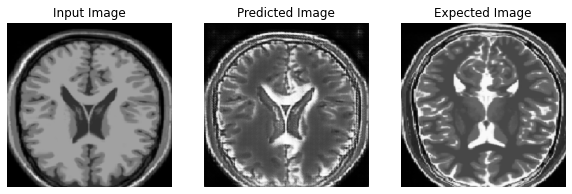

Saving checkpoint for epoch 11 at ./checkpoints/ckpt-12


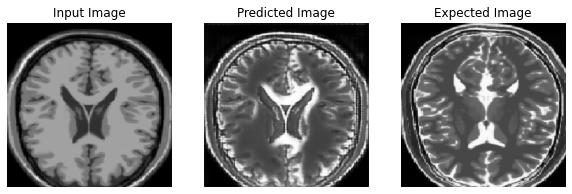

Saving checkpoint for epoch 12 at ./checkpoints/ckpt-13


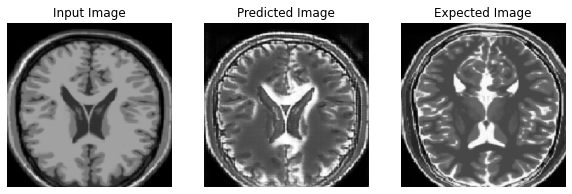

Saving checkpoint for epoch 13 at ./checkpoints/ckpt-14


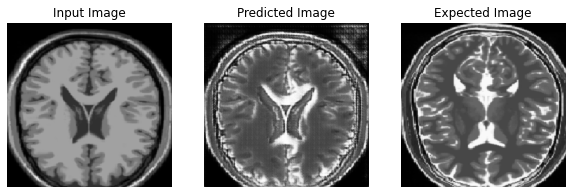

Saving checkpoint for epoch 14 at ./checkpoints/ckpt-15


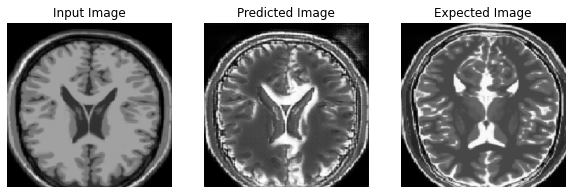

Saving checkpoint for epoch 15 at ./checkpoints/ckpt-16


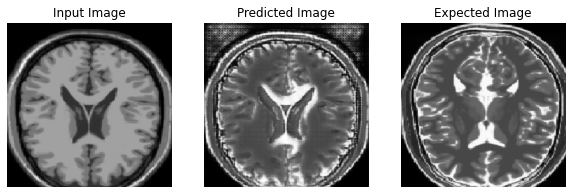

Saving checkpoint for epoch 16 at ./checkpoints/ckpt-17


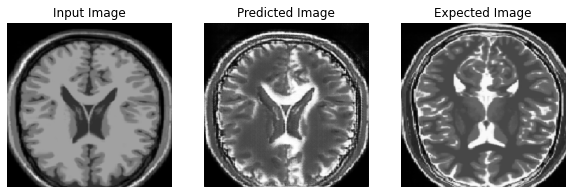

Saving checkpoint for epoch 17 at ./checkpoints/ckpt-18


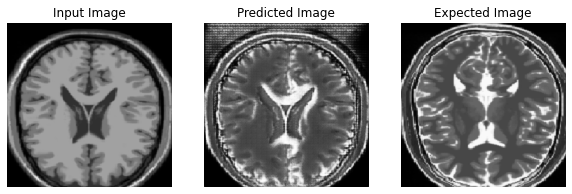

Saving checkpoint for epoch 18 at ./checkpoints/ckpt-19


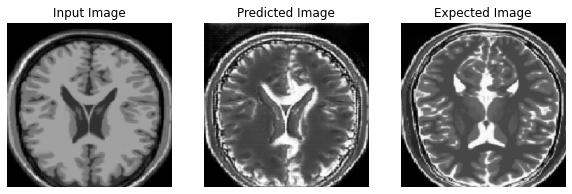

Saving checkpoint for epoch 19 at ./checkpoints/ckpt-20


In [20]:
for epoch in range(EPOCHS):
    for image_x, image_y in tf.data.Dataset.zip((Tr1_slice, Tr2_slice)):
        train_step(image_x, image_y)
    generate_images(generator_g, Tr1_sample, Tr2_sample)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)